### GLAZER FITTING: Explicit refinement of Glazer modes in a PDF of CaTiO3

In [1]:
# Import packages that we will need.
import os
import sys
import yaml
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(os.path.join("utils",
                            "billinge.mplstyle"))

from diffpy.srfit.fitbase import FitContribution, FitRecipe, FitResults, Profile, FitHook
from diffpy.srfit.fitbase.fitresults import initializeRecipe
from diffpy.srfit.structure import constrainAsSpaceGroup
from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.structure import Structure
from scipy.optimize import least_squares

import numpy as np
from sympy import *

%matplotlib inline

In [ ]:
"""
# Group A: High symmetry tilt systems

a0a0a0 ID: 23
a-a-a- ID: 14
a0a0c- ID :22
a0a0c+ ID :21
a0b-b- ID :20
a+b-b- ID :10

# Group B: Multiple A-site tilt systems
a+a+a+ ID :3
a0b-c+ ID :17
a0b+b+ ID :16
a+a+c- ID :5

# Group C: transitional/low symmetry tilt systems
a-a-c- ID :13
a0b-c- ID :19
a-b-c- ID :12
a+b-c- ID :8
a+b+c+ ID :1
"""

In [32]:
def define_initial_glazer_amplitudes(GLAZERSYSTEM): 
    """
    Prompts the user to specify the tilt amplitudes for their chosen Glazer 
    system. Outputs initial tilt amplitudes to be refined.

    Parameters
    ----------
    GLAZERSYSTEM : integer, specifying the Glazer system.

    Returns
    ----------
    tilt_values:   dict, tilt amplitudes alpha, beta and gamma and their values
    """
    
    print('Setting start values for the Glazer tilts in system {}.'.format(GLAZERSYSTEM))

    # Default values:
    a = 0
    b = 0
    c = 0

    # Checking for number of active tilt variables depending on the Glazer system:
    if GLAZERSYSTEM in [22, 21, 20, 16, 14, 11, 7, 3]:
        print('This Glazer system has one tilt degree of freedom. \nPlease type a positive initial tilt amplitude  or leave empty for default.')
        a = float(input('Tilt 1:') or '9')
    if GLAZERSYSTEM in [19, 18, 17, 15, 13, 10, 9, 6, 5, 2]:
        print('This Glazer system has two tilt degrees of freedom. \nPlease choose positive initial tilt amplitudes 1 and 2 or leave empty for default.')
        a = float(input('Tilt 1:') or '9')
        b = float(input('Tilt 2:') or '10')
    if GLAZERSYSTEM in [12, 4, 1]:
        print('This Glazer system has three tilt degrees of freedom. Please choose positive initial tilt amplitudes 1, 2 and 3 or leave empty for default.')
        a = float(input('Tilt 1:') or '9')
        b = float(input('Tilt 2:') or '10')
        c = float(input('Tilt 3:') or '11')

    TILTS = {23: {'alpha': 0, 'beta': 0, 'gamma': 0}, 22: {'alpha': 0, 'beta': 0, 'gamma': -a}, 
               21: {'alpha': 0, 'beta': 0, 'gamma': a}, 20: {'alpha': 0, 'beta': -a, 'gamma': -a}, 
               19: {'alpha': 0, 'beta': -a, 'gamma': -b}, 18: {'alpha': 0, 'beta': a, 'gamma': -b}, 
               17: {'alpha': 0, 'beta': a, 'gamma': -b}, 16: {'alpha': 0, 'beta': a, 'gamma': a}, 
               15: {'alpha': 0, 'beta': a, 'gamma': b}, 14: {'alpha': -a, 'beta': -a, 'gamma': -a}, 
               13: {'alpha': -a, 'beta': -a, 'gamma': -b}, 12: {'alpha': -a, 'beta': -b, 'gamma': -c},
               11: {'alpha': a, 'beta': -a, 'gamma': -a}, 10: {'alpha': a, 'beta': -b, 'gamma': -b}, 
               9: {'alpha': a, 'beta': -a, 'gamma': -b}, 8: {'alpha': a, 'beta': -b, 'gamma': -c}, 
               7: {'alpha': a, 'beta': a, 'gamma': -a}, 6: {'alpha': a, 'beta': b, 'gamma': -b},
               5: {'alpha': a, 'beta': a, 'gamma': -b}, 4: {'alpha': a, 'beta': b, 'gamma': -c}, 
               3: {'alpha': a, 'beta': a, 'gamma': a}, 2: {'alpha': a, 'beta': b, 'gamma': b}, 
               1: {'alpha': a, 'beta': b, 'gamma': c}}
    
    tilt_values = TILTS[GLAZERSYSTEM]
    print('Thank you! Refinement will start with values {}. \nPositive values signify in-phase tilt, negative values signify out-of-phase tilt.\n'.format(list(tilt_values.values())))
    return tilt_values


In [33]:
def A_constraints(GLAZERSYSTEM):
	"""
    Initializes constraints for the A cations according to the chosen Glazer system.

    Parameters
    ----------
    GLAZERSYSTEM : integer, specifying the Glazer system.

    Returns
    ----------
    Acons:         dict containing a 8x3 matrix, gives the constraint equations for the atomic positions
	Avars:         list of strings, variables used in the constraints equations
	AdispI:        list of floats, initial values for A cation displacements
    """
	
	print('Setting up constraints and variables for the A cations in Glazer system {}.'.format(GLAZERSYSTEM))
	
	if GLAZERSYSTEM == 10:
		Acons = {10: 
							[[None, '0.25+Aydisp', '0.25+Azdisp'], 
 							[None, '0.25+Azdisp', '0.75+Aydisp'], 
 							[None, '0.75+Azdisp', '0.25+Aydisp'], 
 							[None, '0.75+Aydisp', '0.75+Azdisp'], 
 							[None, '0.25-Aydisp', '0.25-Azdisp'], 
 							[None, '0.25-Azdisp', '0.75-Aydisp'], 
 							[None, '0.75-Azdisp', '0.25-Aydisp'], 
 							[None, '0.75-Aydisp', '0.75-Azdisp']]}
		Avars = ['Aydisp', 'Azdisp']
		print('Constraints have been created using variables {}. Please input their start values, or leave empty for default.'.format(GLAZERSYSTEM, Avars))
		AdispI = [float(input('A y disp:') or "0.02"), float(input('A z disp:') or "0.01")]
		print('Thank you! Refinement will start with values {}.\n'.format(AdispI))
	else:
		print('You have chosen Glazer system {}. A cation constraints for this system are yet undefined.\n'.format(GLAZERSYSTEM))
	
	return Acons, Avars, AdispI

In [4]:
rotation_pattern = {

'alpha': {'IP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0], [0.5, 0.5, 0.5]],
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0.5], [0.5, 0.5, 0]]},
         'OOP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]], 
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0], [0.5, 0.5, 0.5]]}},

'beta': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0, 0.5, 0.5]]}, 
        'OOP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0.5, 0.5, 0], [0, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]]}},

'gamma': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]}, 
         'OOP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]]}}
                 
}


In [21]:
def rotate_octahedron(octahedron, tilt_values):
    """
    Defines displacement constraints for the oxygens of an octahedron 
    using the Glazer variables.
    
    Takes in the positions of the three oxygens and its pivot 
    atom of an octahedron and the Glazer system number and creates symbolic 
    expressions for the positions of the oxygens.

    Parameters
    ----------
    octahedron:    4x3 matrix of atomic positions (floats)
    GLAZERSYSTEM : integer, specifying the Glazer system.

    Returns
    ----------
    Xs_cons:        3x3 matrix of symbolic expressions, constraints for the x,y and z oxygen (X) positions
    Glazer_vars:    sympy variables for alpha, beta and/or gamma, depinding on the Glazer system
    """

    amp = {}
    pattern_indicator = {}
    sign = {}
    Xs_disp = {}
    axes = np.array([[1,0,0], [0,1,0], [0,0,1]])
    
    # Fetch initial position for pivot atom (B) and the three oxygens:
    B = octahedron[0]
    Xs = octahedron[1:4]
    # Shift the octahedron to the origin:
    Xs_rel = Xs - B
    
    # define active variables
    glazer_vars = [Symbol('alpha_var'), Symbol('beta_var'), Symbol('gamma_var')]
    amps = tilt_values['alpha'], tilt_values['beta'], tilt_values['gamma']
    for i in [1,2]:
        if abs(amps[i]) == abs(amps[i-1]):
            glazer_vars[i] = glazer_vars[i-1]
    
    for i in range(len(glazer_vars)):
        if amps[i] == 0:
            glazer_vars[i] = 0

    # Go through all the Glazer amplitudes, alpha, beta and gamma and fetch relevant rotation pattern
    i = 0
    for key in tilt_values.keys():
        amp[key] = np.abs(float(tilt_values[key]))
        pattern_indicator[key] = np.sign(tilt_values[key])
        if amp[key] > 0:
            if pattern_indicator[key] > 0:
                typ = 'IP'
            if pattern_indicator[key] < 0:
                typ = 'OOP'
                
            # set sign of rotation for the current octahedron
            if list(B) in rotation_pattern[key][typ]['clockwise']:
                sign[key] = +1
            if list(B) in rotation_pattern[key][typ]['anti-clockwise']:
                sign[key] = -1
            
        if amp[key] == 0:
            sign[key] = 0
        
        # Define displacement from cubic position around axis 
        R = axes[i]
        Xs_disp[key] = symarray('', len(Xs))
        for j in range(len(Xs_rel)):
            x = Xs_rel[j]
            disp_dir = Matrix(np.nan_to_num(np.cross(R, x) / np.linalg.norm(np.cross(R, x))))
            x_scaled = Matrix(x).multiply(cos(glazer_vars[i]/180*pi)) # length of vector*cosine
            x_scaled_len = sqrt((x_scaled[0])**2 + (x_scaled[1])**2 + (x_scaled[2])**2)
            disp_amp = x_scaled_len * tan(sign[key]*glazer_vars[i]/180*pi)
            x_disp = disp_dir * disp_amp
            Xs_disp[key][j] = x_disp
    
        i = i+1
    
    # Combining all relative around all three axes displacements
    Xs_disp_all = Xs_disp['alpha'] + Xs_disp['beta'] + Xs_disp['gamma']
    
    # Create constraints equations for all oxygens by adding the old positions
    Xs_cons = symarray('', len(Xs))
    for i in range(len(Xs)):
        Xs_cons[i] = Xs_disp_all[i] + Matrix(Xs[i])

    return Xs_cons, glazer_vars

In [6]:
def lattice_parameters_constraints(octahedron_disp, a_par, nx, ny, nz):
    """
    Defines constraints for the lattice parameters with the Glazer variables.
    
    Takes in the positions of the three oxygens and its pivot 
    atom (octahedron) and the Glazer system and creates a symbolic 
    expression for the new positions of the oxygens.

    Parameters
    ----------
    octahedron_disp:  4x3 matrix of symbolic expressions, atomic positions of any octahedron
    a_par:            sympy variable, cubic lattice parameter
    nx, ny, nz:       int x 3, dimensions of the distorted supercell.    

    Returns
    ----------
    a_new:            symbolic expression, constraint equation for the new a lattice parameter
    b_new:            symbolic expression, constraint equation for the new b lattice parameter
    c_new:            symbolic expression, constraint equation for the new c lattice parameter
    """

    print('Setting up constraints for the lattice parameters using the Glazer tilt variables.\n')

    # Breaking up the octahedron in the pivot atom and three oxygens:
    B = octahedron_disp[0]
    X1 = octahedron_disp[1]
    X2 = octahedron_disp[2]
    X3 = octahedron_disp[3]

    # Shifting the octahedron to the origin:
    O1x, O1y, O1z = X1 - B
    O2x, O2y, O2z = X2 - B
    O3x, O3y, O3z = X3 - B
    
    # Using the solutions from evaluating the compression of the supercell, 
    # define scaling factors for the lattice parameters
    a_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    a_den = 1 - 16*O1y**2 + 16*(-1+16*O3y**2)*O1z**2 + 256*(O1y**2-O3y**2)*O2z**2
    scale_a = sqrt(a_num/a_den)

    b_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    b_den = 1 + 16*O2x**2 *(-1 + 16*O1z**2) - 16*O2z**2 + 256*O3x**2 *(-O1z**2 + O2z**2)
    scale_b = sqrt(b_num/b_den)

    c_num = -1 + 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) + 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    c_den = -1 + O3x**2 *(16-256*O1y**2) + 256*O2x**2 *(O1y**2 - O3y**2) + 16*O3y**2
    scale_c = sqrt(c_num/c_den)
    
    # Divide the cubic lattice parameters with the scaling factors for each axis:
    a = Symbol(a_par)
    a_new = a*nx/scale_a
    b_new = a*ny/scale_b
    c_new = a*nz/scale_c
    
    return a_new, b_new, c_new

In [128]:
#test
octa = np.array([[0.0, 0.5, 0.0],
                [0.25, 0.5, 0.0],
                [0.0, 0.75, 0.],
                [0.0, 0.5, 0.25]])
GS = 10

A_cons, A_vars, Adisp_I = A_constraints(GS)

tilt_values = define_initial_glazer_amplitudes(GS)

Xs_newt, variables_active = rotate_octahedron(octa, GS)
print(Xs_newt)

octa_disp = Matrix(octa[0]), Xs_newt[0], Xs_newt[1], Xs_newt[2]
a_newt, b_newt, c_newt = lattice_parameters_constraints(octa_disp, 'a_cubic', 2, 2, 2)
print(a_newt, b_newt, c_newt)

You have chosen Glazer system 10. 
Constraints for the A cations have been defined using variables ['Aydisp', 'Azdisp']
Refinement will start with values [0.1, 0.1].
You have chosen Glazer system 10, which has two tilt degrees of freedom. Choose positive initial tilt amplitudes a and b.
Refinement will start with values {'alpha': 9.0, 'beta': -10.0, 'gamma': -10.0}. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.
Creating variables for octahedron [0.  0.5 0. ]
[Matrix([
 [                                                          0.25],
 [-0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180) + 0.5],
 [       0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)]])
 Matrix([
 [   0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)],
 [                                                      0.75],
 [-0.25*sqrt(cos(pi*alpha_var/180)**2)*tan(pi*alpha_var/180)]])
 Matrix([
 [       -0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)],
 [0.25*sqr

/home/sandraskj/anaconda3/envs/diffpy/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


In [7]:
def plotresults(recipe, resfithook, figname):
    """
    Creates plots of the fitted PDF and residual, displays them, and
    then writes them to disk as *.pdf files.

    Parameters
    ----------
    recipe :     The optimized Fit Recipe object containing the PDF data
                 we wish to plot
    resfithook:  
    figname :    string, the location and name of the figure file to create

    Returns
    ----------
    None
    """
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.65 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero


    fig, ax = plt.subplots(2, 1)

    ax[0].plot(r, g, ls="None",
             marker="o", ms=3, mew=0.2,
             mfc="None", label="$G(r)$ Data")
    ax[0].plot(r, gcalc, lw=1.3, label="$G(r)$ Fit")
    ax[0].plot(r, diff, lw=1.2, label="$G(r)$ diff")
    ax[0].plot(r, diffzero, lw=1.0, ls="--", c="black")
    ax[0].set_xlabel("$r$ [$\mathrm{\AA}]$")
    ax[0].set_ylabel("$G$ [$\mathrm{\AA}$$^{-2}$]")
    ax[0].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)
    ax[0].set_xlim(PDF_RMIN, PDF_RMAX)
    ax[0].legend()
    

    ax[1].plot(resfithook.rws, lw=1.0, marker='o', c="black")
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("rw")
    ax[1].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)

    plt.tight_layout()
    plt.show()
    fig.savefig(figname + ".pdf", format="pdf")

    # End of function

In [22]:
def makerecipe(stru1, datname):
    """
    Creates and returns a Fit Recipe object.
    Make the recipe that the fit will follow.
    This Fit recipe object contains the PDF data, the model structure,
    the constraints and variables necessary to run the fit.
    

    Parameters
    ----------
    stru1 :     diffpy structure object, contains the structure used to fit
                the PDF data
    datname :   string, The location and filename containing the PDF data to be fit

    Returns
    ----------
    fitrecipe : The initialized Fit Recipe object using the datname and stru1
                provided
    """

    ########################### Profile Section ###################################
    # Create a Profile object for the experimental dataset. This handles all details
    # about the dataset. We also tell this profile the range and mesh of points in 
    # r-space.
    
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=PDF_RMIN, xmax=PDF_RMAX, dx=PDF_RSTEP)

    ########################## PDF Generator Section ##############################
    # Create a PDF Generator object for a periodic structure model. Here we name it
    # "G1" and we give it the structure object. This Generator will later compute
    # the model PDF for the structure object we provide it here.
    generator_crystal = PDFGenerator("G1")
    generator_crystal.setStructure(stru1, periodic=True)

    # Initialize the instrument parameters, Q_damp and Q_broad, and assign Q_max and
    # Q_min, all part of the PDF Generator object. It's possible that the PDFParse
    # function we used above already parsed out ths information, but in case it
    # didn't, we set it explicitly again here. All parameter objects can have their
    # value assigned using the below ".value = " syntax.
    generator_crystal.qdamp.value = QDAMP_I
    generator_crystal.qbroad.value = QBROAD_I
    generator_crystal.setQmax(QMAX)
    generator_crystal.setQmin(QMIN)

    # If you have a multi-core computer (you probably do), you can run your 
    # refinement in parallel! This requires that you set "RUN_PARALLEL" to "True" 
    # above. The psutil python package is also required for the bit of code below,
    # where we make sure not to overload your CPUs.
    if RUN_PARALLEL:
        import psutil
        import multiprocessing
        syst_cores = multiprocessing.cpu_count()
        cpu_percent = psutil.cpu_percent()
        avail_cores = np.floor((100 - cpu_percent) / (100.0 / syst_cores))
        ncpu = int(np.max([1, avail_cores]))
        generator_crystal.parallel(ncpu)

    ######################### Fit Contribution Section ############################
    # Create a Fit Contribution object, and name it "crystal." We then give the PDF
    # Generator object we created just above to this Fit Contribution object.
    # The Fit Contribution holds the equation used to fit the PDF.
    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal)

    # Set an equation, within the Fit Contribution, based on your PDF Generators.
    # Here we simply have one Generator, G1, and a scale variable, s1.
    # Using this structure is a very flexible way of adding additional
    # Generators (ie. multiple structural phases), experimental Profiles,
    # PDF characteristic functions (ie. shape envelopes), and more.
    contribution.setEquation("s1*G1")

    # Set the experimental profile, within the Fit Contribution object, to the 
    # Profile object we created earlier.
    contribution.setProfile(profile, xname="r")

    ######################### Recipe Section ######################################
    # Create the Fit Recipe object that holds all the details of the fit, defined in
    # the lines above. We give the Fit Recipe the Fit Contribution we created earlier.
    recipe = FitRecipe()
    recipe.addContribution(contribution)

    # Configure some additional fit variables pertaining to symmetry. We can use the
    # srfit function constrainAsSpaceGroup to constrain the lattice and ADP
    # parameters. We are not using symmetry constraints in this code, but we still
    # initialize a P1 symmetry so that we can use the parameters generated to create
    # our own constraints.
    # First we establish the relevant parameters, splitting the structure into its 
    # elemental sublattices, A, B and X then we cycle through the parameters and
    # activate and tag them. This gives us the flexibility to use symmetry constraints
    # for the A cations will creating our Glazer tilt constraints manually. We must 
    # explicitly set the ADP parameters, because in this case, the CIF has no ADP data.
    # Currently, the A atoms are also constrained manually, so we initialize P1 for all
    # atoms.
    
    #Get the atoms:
    atoms = generator_crystal.phase.getScatterers()
    A_atoms = atoms[0:8]
    B_atoms = atoms[8:16]
    X_atoms = atoms[16:]
    
    spacegroupparams_A = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=A_atoms,
                                              constrainlat=False)
    spacegroupparams_X = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=X_atoms)
    
    # Create dicts of position and lists of indices for all three atom types.
    A_dict, B_dict, X_dict = {}, {}, {}
    A_index, B_index, X_index  = [], [], []
    for i,atom in enumerate(atoms):
        if atom.element == ELEMENT_X_I:
            X_index.append(i)
            X_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == ELEMENT_B_I:
            B_index.append(i)
            B_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == ELEMENT_A_I:
            A_index.append(i)
            A_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}

    x1_index = X_index[0*8:8*1]
    x2_index = X_index[1*8:8*2]
    x3_index = X_index[2*8:8*3]
    
    # Create dict for indices and xyzpars of oxygen spacegroup params
    index_xyzpars_X_dict = {}
    for par in spacegroupparams_X.xyzpars:
        atom_index = int(par.name.split("_")[-1]) +16
        if not atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index].append(par)
    
    index_xyzpars_A_dict = {}
    for par in spacegroupparams_A.xyzpars:
        atom_index = int(par.name.split("_")[-1])
        if not atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index].append(par)
    
    ######################## VARIABLES and CONSTRAINTS #################################
    ####################################################################################
    # Now that we have the parameters, we can set up the structure variables that are 
    # to be refined, and the values they are to be initialized with.
    
    # Add a variable to the Fit Recipe object, initialize the variables with some value, 
    # and tag it with a string. Here we add the scale parameter from the Fit Contribution,
    # delta and instrumental parameters. The ".addVar" method can be used generally to add
    # variables to the Fit Recipe.
    recipe.addVar(contribution.s1, SCALE_I, tag="scale")
    recipe.addVar(generator_crystal.delta2, name="Delta2", value=DELTA2_I, tag="d2")
    recipe.addVar(generator_crystal.qdamp, name="qdamp", value=QDAMP_I, tag="qdamp")
    recipe.addVar(generator_crystal.qbroad, name="qbroad", value=QBROAD_I, tag="qbroad")
    
    # For the atom positions, we have to create new variables, since we are not using
    # the parameters that come out of the ConstrainAsSpacegroup directly. Then we can
    # link these new variables to the parameters. Note that the variable names given 
    # here are the same as those used in the A_con list, as initialized in cell 3.
    
    # Variables, start values and constraints for A cations
    A_cons, A_vars, Adisp_I = A_constraints(GLAZERSYSTEM)
    for Avar, AvarI in zip(A_vars, Adisp_I):     
        recipe.newVar(Avar, AvarI, tag=Avar)

    for i in range(len(A_cons)):
        for j in range(3):
            A_par = index_xyzpars_A_dict[i][j]
            A_con = A_cons[GLAZERSYSTEM][i][j]
            
            if A_con != None:
                recipe.constrain(A_par, "{}".format(A_con))
    
    
    # Initialize variables for the cubic lattice parameter
    recipe.newVar("a_var", LAT_A_I, tag="a_var")

    # Go through all the octahedra and fetch variable expressions for the constraints
    # Use the first octahedron to initizalize the glazer variables

    tilt_values = define_initial_glazer_amplitudes(GLAZERSYSTEM)

    print('Setting up constraints for the oxygens using the Glazer tilt variables.\n')
    for n in range(len(B_index)):
        # Find the atoms in the unit and define vectors between the X's and
        # B cation, setting B as a reference point around which to rotate:
        B_pos = B_dict[str(B_index[n])][ELEMENT_B_I]
        X1_pos = X_dict[str(x1_index[n])][ELEMENT_X_I]
        X2_pos = X_dict[str(x2_index[n])][ELEMENT_X_I]
        X3_pos = X_dict[str(x3_index[n])][ELEMENT_X_I]
        octahedron = np.array([B_pos, X1_pos, X2_pos, X3_pos])
        Xs_con, glazer_vars = rotate_octahedron(octahedron, tilt_values)

        # Create variables for the active glazer tilt variables:
        if n == 0:
            glazer_vars = [var for var in glazer_vars if var != 0]
            i = 0
            l = []
            for v in glazer_vars:
                if v not in l:
                    recipe.newVar("{}".format(v), list(tilt_values.values())[i], fixed=False, tag="{}".format(v))
                    l.append(v)
                i = i + 1

        # Loop through all x, y and z components and add constraints
        for i in range(3):
            X1_par = index_xyzpars_X_dict[x1_index[n]][i]
            X2_par = index_xyzpars_X_dict[x2_index[n]][i]
            X3_par = index_xyzpars_X_dict[x3_index[n]][i]

            X1_con = Xs_con[0][i]
            X2_con = Xs_con[1][i]
            X3_con = Xs_con[2][i]

            recipe.constrain(X1_par, "{}".format(X1_con))
            recipe.constrain(X2_par, "{}".format(X2_con))
            recipe.constrain(X3_par, "{}".format(X3_con))
    
    # Set up constraints for the lattice parameters based on the refinable variables for
    # the cubic lattice parameter a_var and the glazer tilt amplitudes relevant for the mode
    B = B_dict[str(B_index[-1])][ELEMENT_B_I]
    octa_disp = Matrix(B), Xs_con[0], Xs_con[1], Xs_con[2]
    a_con, b_con, c_con = lattice_parameters_constraints(octa_disp, 'a_var', 2, 2, 2)
    
    for par in spacegroupparams_X.latpars:
        if par.name == "a":
            recipe.constrain(par, "{}".format(a_con))
        if par.name == "b":
            recipe.constrain(par, "{}".format(b_con))
        if par.name == "c":
            recipe.constrain(par, "{}".format(c_con))
    
    # Add Uiso parameter for each element.
    elements = collections.Counter([atom.element for atom in atoms]).keys()
    dct = {}
    for element in elements:
        if element == ELEMENT_A_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_A_I, tag=f"Uiso_{element}")
        elif element == ELEMENT_B_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_B_I, tag=f"Uiso_{element}")
        elif element == ELEMENT_X_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_X_I, tag=f"Uiso_{element}")
        dct[element] = var
    for atom in atoms:
        recipe.constrain(atom.Uiso, dct.get(atom.element))

 
    # Return the Fit Recipe object to be optimized
    return recipe

    # End of function


In [9]:
class ResidualFitHook(FitHook):

    def __init__(self):
        super(ResidualFitHook, self).__init__()
        self.rws = []

    def reset(self, recipe):
        self.rws = []

    def postcall(self, recipe, chiv):
        recipe: FitRecipe
        fc: FitContribution = next(iter(recipe._contributions.values()))
        rw = np.sqrt(np.sum(np.power(chiv, 2)) / np.sum(np.power(fc.profile.y, 2)))
        self.rws.append(rw)

In [35]:
def main():
    """
    Main function for a refinement.


    Returns
    ----------
    Fit residual
    """
    
    FIT_ID_BASE = "{}_GS_{}_test".format(compound, GLAZERSYSTEM)
    
    # Make some folders to store our output files.
    resdir = "output/res"  # Contains results files
    fitdir = "output/fit"  # Contains fit 
    figdir = "output/fig"  # Contains plot of fit
    strdir = "output/str"  # Contains refined structures
    vardir = 'output/var/'

    folders = [resdir, fitdir, figdir, strdir, vardir]

    # Loop over all folders
    for folder in folders:

        # If the folder does not exist...
        if not os.path.exists(folder):

            # ...then we create it.
            os.makedirs(folder)


    # Establish the location of the cif file with the structure of interest
    # and load it into a diffpy structure object.
    moddir = os.path.abspath(MPATH)
    #if REF_TYPE == 'initial':
    stru1 = Structure(filename=os.path.join(moddir, CIF_NAME))

    # Initialize the Fit Recipe by giving it this diffpy structure
    # as well as the path to the data file.
    #temp = list(filepaths.keys())[0]
    recipe = makerecipe(stru1, GR_NAME)
    all_variables = recipe.getNames()
    
    # Set fithooks to get step values
    recipe.fithooks.clear()
    resfithook = ResidualFitHook()
    recipe.fithooks.append(resfithook)
   
    
    # Tell the Fit Recipe we want to write the minimum amount of information
    # to the terminal during fitting. This does not work currently.
    #recipe.fithooks[0].verbose = 2


    # Print out list of glazer variables and A cation variables to fit
    A_variables = []
    for v in all_variables:
        if v in ['Aydisp', 'Azdisp']:
            A_variables.append(v)
    #print('A cation variables to refine {}'.format(A_variables))

    glazer_variables = []
    for v in all_variables:
        if v in ['alpha_var', 'beta_var', 'gamma_var']:
            glazer_variables.append(v)
    #print('Glazer variables to refine {}'.format(glazer_variables))


    refined_dict = dict()

    basename = "{}".format(FIT_ID_BASE) + "_r_{}-{}".format(PDF_RMIN, PDF_RMAX)
    
    parser = PDFParser()
    parser.parseFile(GR_NAME)
    recipe.crystal.profile.loadParsedData(parser)
    
    ######################### Refinement steps ######################################
    # During the optimization, we fix and free parameters sequentially as you would
    # in PDFgui. This leads to more stability in the refinement. We first fix all
    # variables. "all" is a tag which incorporates every parameter.
    
    # We then run a fit using the SciPy function "least_squares" which takes as its
    # arguments the function to be optimized, here recipe.residual, as well as initial
    # values for the fitted parameters, provided by recipe.values. The x_scale="jac"
    # argument is an optional argument that provides for a bit more stability in the
    # refinement. "least_squares" is a bit more robust than "leastsq," which is another
    # optimization function provided by SciPy. "least_squares" supports bounds on
    # refined parameters, while "leastsq" does not.
     #sys.exit()
    print('Starting refinement {}...'.format(basename))
    recipe.fix("all")
    recipe.free("scale")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("a_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])
    
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    for i in range(len(A_variables)):
        recipe.fix(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])

    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    
    recipe.fix("all")
    recipe.free("scale")
    recipe.free("a_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.fix("all")
    recipe.free("scale")
    recipe.free("a_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.fix("all")
    recipe.free("d2")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.free("all")
    recipe.fix("qdamp")
    recipe.fix("qbroad")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    # We use the savetxt method of the profile to write a text file containing the
    # measured and fitted PDF to disk. The file is named based on the basename we
    # created earlier, and written to the fitdir directory.
    profile = recipe.crystal.profile
    profile.savetxt(os.path.join(fitdir, basename + ".fit"))
    print('Dumped {}'.format(os.path.join(fitdir, basename + ".fit")))

    # We use the FitResults function to parse out the results from the optimized
    # Fit Recipe.
    res = FitResults(recipe)

    # We print these results to the terminal.
    res.printResults()

    # We use the saveResults method of FitResults to write a text file containing the
    # refined parameters and fit quality indices to disk. The file is named based on
    # the basename we created earlier, and written to the resdir directory.
    header = "{}_{}.\n".format(compound, basename)
    res.saveResults(os.path.join(resdir, basename + ".res"), header=header)
    print('Dumped {}'.format(os.path.join(resdir, basename + ".res")))

    # Write out updated model structure
    pg = recipe.crystal.G1
    stru: diffpy.structure.structure.Structure = pg.stru
    stru.write("{}/{}.cif".format(strdir, basename), "cif")
    print('Dumped {}'.format("{}/{}.cif".format(strdir, basename)))
        
    refined_dict = dict()
    for name, val in zip(res.varnames, res.varvals):
        # We create a new nested dictionary based on each variable name
         # We store the refined value for this variable using the "value" key.
        # We use the ".item()" method because "res.varvals" exist as
        # numpy.float64 objects, and we want them as regular python floats.
        refined_dict[name] = val.item()


    # We also store the fit rw, for posterity.
    rw = res.rw
    refined_dict['rw'] = rw.item()

    # We use the plotresults function we created earlier to make a plot of the measured
    # calculated, and difference curves. We show this as an interactive window and then
    # write a pdf file to disk. The file is named based on the basename we created
    # earlier, and written to the figdir directory.
    plotresults(recipe, resfithook, os.path.join(figdir, basename))
    # plt.ion()
    
    # We now write this dictionary to a file for later use.
    outfilename = vardir + FIT_ID_BASE + "_r_" + str(PDF_RMIN) + "-" + str(PDF_RMAX) + "_refined_params.yml"
    with open(outfilename, 'w') as outfile:
        #outpath = os.path.join(var_dir, outfilename)
        yaml.safe_dump(refined_dict, outfile)
    print('Dumped {}'.format(outfilename))

    return

In [40]:
### PARAMETERS AND VARIABLES NOT TO BE REFINED

# Give the elements in the perovskite
ELEMENT_A_I = "Ca"    # I suggest to get this from the cif file
ELEMENT_B_I = "Ti"    # I suggest to get this from the cif file
ELEMENT_X_I = "O"     # I suggest to get this from the cif file
compound = "{}{}{}3".format(ELEMENT_A_I, ELEMENT_B_I, ELEMENT_X_I)

QMAX = 23.6
QMIN = 0.6

QDAMP_I = 0.0291601718936 # from Ni calibration, do not refine
QBROAD_I = 0.0103215402787 # from Ni calibration

PDF_RMIN = 1.6
PDF_RMAX = 9.6
PDF_RSTEP = 0.01

RUN_PARALLEL = True

In [38]:
######## START VALUES TO BE REFINED ######################
LAT_A_I =  3.90 

UISO_A_I = 0.002 # allow to refine
UISO_B_I = 0.002 # allow to refine
UISO_X_I = 0.01 # allow to refine

DELTA2_I = 1.95202664  # from fitting 1.6-9.6, allow to refine
SCALE_I = 0.2

In [14]:
############### LOADING Data and models ##############################
DPATH = 'input/data/'
GR_NAME = 'input/data/B_CaTiO3_PDF_Tseries_100_T_200.0K_DetZ_3810.gr'

MPATH = 'input/models'
CIF_NAME = "CaTiO3_2x2x2-supercell_0_0_0_tilt.cif"   ## This is not optional, it has to be a 2x2x2 cubic supercell

Setting up constraints and variables for the A cations in Glazer system 10.
Constraints have been created using variables 10. Please input their start values, or leave empty for default.
Thank you! Refinement will start with values [0.02, 0.01].

Setting start values for the Glazer tilts in system 10.
This Glazer system has two tilt degrees of freedom. 
Please choose positive initial tilt amplitudes 1 and 2 or leave empty for default.
Thank you! Refinement will start with values [9.0, -10.0, -10.0]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Setting up constraints for the oxygens using the Glazer tilt variables.

Setting up constraints for the lattice parameters using the Glazer tilt variables.

Starting refinement CaTiO3_GS_10_test_r_1.6-9.6...


/home/sandraskj/anaconda3/envs/diffpy/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


Dumped output/fit/CaTiO3_GS_10_test_r_1.6-9.6.fit
Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       12.45078078
Contributions  12.45078078
Restraints     0.00000000
Chi2           12.45078078
Reduced Chi2   0.01574056
Rw             0.22435238

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Aydisp     2.47132294e-02 +/- 1.56752964e-01
Azdisp     1.10299813e-02 +/- 1.75158313e-01
Delta2     2.10359975e+00 +/- 1.23659285e+00
Uiso_Ca    1.76754199e-02 +/- 1.10373624e-02
Uiso_O     1.21355412e-02 +/- 4.71947762e-03
Uiso_Ti    2.16304838e-03 +/- 8.59195976e-04
a_var      3.90347691e+00 +/- 1.46824996e-02
alpha_var  8.73386059e+00 +/- 8.99454698e+00
beta_var   -9.17924582e+00 +/- 4.29246075e+00
s1         1.80453304e-01 +/- 2.10370236e-02

Fixed Variables
-------------------------------

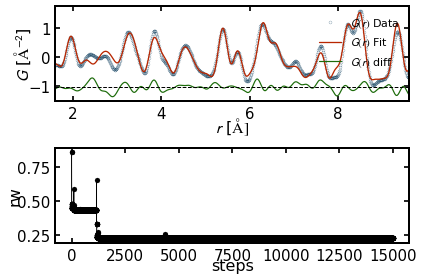

Dumped output/var/CaTiO3_GS_10_test_r_1.6-9.6_refined_params.yml


In [41]:
GLAZERSYSTEM = 10
if __name__ == "__main__":
    main()